**Kapitel 4 – Modelle trainieren**

Dieses Notizbuch enthält den gesamten Beispielcode und die Lösungen zu den Übungen in Kapitel 4.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

Zunächst importieren wir einige gängige Module, stellen sicher, dass MatplotLib Zahlen inline plottet und bereiten eine Funktion zum Speichern der Zahlen vor. Wir überprüfen auch, ob Python 3.5 oder höher installiert ist (Python 2.x kann zwar funktionieren, ist aber veraltet, so dass wir dringend empfehlen, stattdessen Python 3 zu verwenden), sowie Scikit-Learn ≥0.20.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In diesem Kapitel befassen wir uns zunächst mit dem Modell der linearen Regression, einem der einfachsten Modelle, die es gibt. Wir werden zwei sehr unterschiedliche Methoden zum Trainieren des Modells diskutieren:

- Mit Hilfe einer direkten "geschlossenen" Gleichung, die direkt die Modellparameter berechnet, die das Modell am besten an die Trainingsmenge anpassen (d. h. die Modellparameter, die die Kostenfunktion über die Trainingsmenge minimieren).

- Verwendung eines iterativen Optimierungsansatzes namens Gradient Descent (GD), der die Modellparameter schrittweise optimiert, um die Kostenfunktion über die Trainingsmenge zu minimieren, und schließlich zum gleichen Parametersatz wie bei der ersten Methode konvergiert. Wir werden uns einige Varianten des Gradientenabstiegs ansehen, die wir bei der Untersuchung neuronaler Netze in Teil II immer wieder verwenden werden: Batch GD, Mini-batch GD und Stochastic GD.

Als Nächstes werden wir uns mit der polynomiellen Regression beschäftigen, einem komplexeren Modell, das sich an nichtlineare Datensätze anpassen lässt. Da dieses Modell mehr Parameter als die lineare Regression hat, ist es anfälliger für eine Überanpassung der Trainingsdaten. Daher werden wir uns ansehen, wie man mit Hilfe von Lernkurven feststellen kann, ob dies der Fall ist, und wir werden uns dann verschiedene Regularisierungstechniken ansehen, die das Risiko einer Überanpassung der Trainingsmenge verringern können.

Schließlich werden wir uns zwei weitere Modelle ansehen, die häufig für Klassifizierungsaufgaben verwendet werden: Logistische Regression und Softmax-Regression.

# Linear Regression

Allgemeiner ausgedrückt: Ein lineares Modell macht eine Vorhersage, indem es eine gewichtete Summe der Eingangsmerkmale plus eine Konstante, den so genannten Bias-Term (auch Intercept-Term genannt), berechnet, wie in Gleichung 4-1 dargestellt.

$$ \hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n $$

In dieser Gleichung bedeuten:

- $\hat{y}$ ist der vorhergesagte Wert.
- $n$ ist die Anzahl der Merkmale.
- $x_i$ ist der $i$-te Merkmalswert.
- $\theta_j$ ist der $j$-te Modellparameter (einschließlich des Bias-Terms $\theta_0$ und der Merkmalsgewichte $\theta_1$, $\theta_2$, $\ldots$ , $\theta_n$).


Dies lässt sich mit Hilfe einer vektorisierten Form, wie in Gleichung 4-2 gezeigt, viel prägnanter darstellen:

$$ \hat{y} = h_{\mathbf{\theta}}(\mathbf{x}) = \mathbf{\theta} \cdot \mathbf{x} $$

In dieser Gleichung bedeuten:

- $\mathbf{\theta}$ ist der Parametervektor des Modells, der den Bias-Term $\theta_0$ und die Merkmalsgewichte $\theta_1$ bis $\theta_n$ enthält.
- $\mathbf{x}$ ist der Merkmalsvektor der Instanz, der $x_0$ bis $x_n$ enthält, wobei $x_0$ immer gleich 1 ist.
- $\mathbf{\theta} \cdot \mathbf{x}$ ist das Punktprodukt oder Skalarprodukt der Vektoren $\mathbf{\theta}$ und $\mathbf{x}$, das natürlich gleich $\theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n$ ist.
- $h_{\mathbf{\theta}}(\mathbf{x})$ ist die Hypothesenfunktion, die die Modellparameter \mathbf{\theta}$ verwendet.



OK, das ist das lineare Regressionsmodell - aber wie trainieren wir es? Wir erinnern uns: Ein Modell zu trainieren bedeutet, seine Parameter so einzustellen, dass das Modell am besten zu den Trainingsdaten passt. Zu diesem Zweck benötigen wir zunächst ein Maß dafür, wie gut (oder schlecht) das Modell zu den Trainingsdaten passt. In Kapitel 2 haben wir gesehen, dass das gängigste Maß für die Leistung eines Regressionsmodells der mittlere quadratische Fehler (**Root Mean Square Error, RMSE**) ist (Gleichung 2-1). Um ein lineares Regressionsmodell zu trainieren, müssen wir daher den Wert von $\mathbf{\theta}$ finden, der den RMSE minimiert. In der Praxis ist es einfacher, den mittleren quadratischen Fehler (MSE) zu minimieren als den RMSE, und es führt zum gleichen Ergebnis (weil der Wert, der eine Funktion minimiert, auch ihre Quadratwurzel minimiert).

Der MSE einer linearen Regressionshypothese $h_{\mathbf{\theta}}$ für eine Trainingsmenge $X$ wird mit Gleichung 4-3 berechnet.

$$ MSE(\mathbf{X}, h_{\mathbf{\theta}}) = \cfrac{1}{m} \sum_{i=1}^m \left( \mathbf{\theta}^T \mathbf{x}^{(i)} - y^{(i)}\right)^2 $$


## Die Normalgleichung

Um den Wert von $\mathbf{\theta}$ zu finden, der die Kostenfunktion minimiert, gibt es eine geschlossene Lösung - mit anderen Worten, eine mathematische Gleichung, die das Ergebnis direkt angibt. Diese wird als Normalgleichung bezeichnet (Gleichung 4-4).

$$ \hat{\mathbf{\theta}} = \left( \mathbf{X}^T \mathbf{X} \right)^{-1}\mathbf{X}^T\mathbf{y} $$

In dieser Gleichung bedeuten:
- $\hat{\mathbf{\theta}}$ ist der Wert für $\mathbf{\theta}$, der die Kostenfunktion minimiert.
- $\mathbf{y}$ ist der Target-Vektor, der die Werte $y^{(1)}$ bis $y^{(m)}$ enthält.

In [3]:
# Generiere Testdaten
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


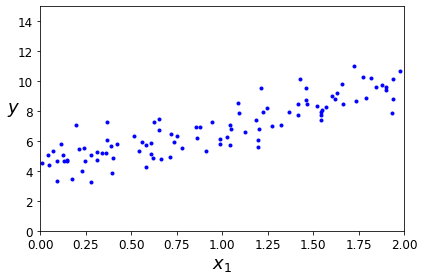

In [4]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [5]:
# Wir berechnen die Lösung für die lin. Reg. per Normalgleichung
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [6]:
theta_best # stimmt mit unserer wahren Gleichung (b=4, m=3) fast überein

array([[4.21509616],
       [2.77011339]])

Wir hätten uns $\theta_0 = 4$ und $\theta_1 = 3$ anstelle von $\theta_0 = 4,215$ und $\theta_1 = 2,770$ gewünscht. Das war nahe genug, aber das Rauschen machte es unmöglich, die genauen Parameter der ursprünglichen Funktion wiederherzustellen.

In [7]:
# Vorhersagen
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

The figure in the book actually corresponds to the following code, with a legend and axis labels:

Saving figure linear_model_predictions_plot


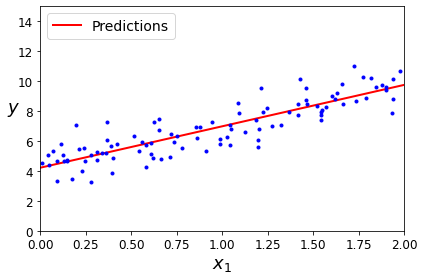

In [8]:
# Visualisiere die gefundene Geradengleichung
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

In [9]:
# Jetzt nutzen wir LinearRegression von sklearn
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [10]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

Die Klasse `LinearRegression` basiert auf der Funktion `scipy.linalg.lstsq()` (der Name steht für "kleinste Quadrate"), die Sie direkt aufrufen können:

In [11]:
# Berechnung von Hand via numpy linalg package
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [12]:
# Berechnung der pseudoinversen von Hand
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

Die Normalgleichung berechnet die Inverse von $X^TX$, die eine $(n + 1) × (n + 1)$ Matrix ist (wobei $n$ die Anzahl der Merkmale ist). Der Rechenaufwand für die Invertierung einer solchen Matrix liegt je nach Implementierung bei $O(n^{2,4})$ bis $O(n^3)$. Mit anderen Worten, wenn Sie die Anzahl der Merkmale verdoppeln, multiplizieren Sie die Rechenzeit um etwa $2^{2,4} = 5,3$ bis $2^3 = 8$.

Der SVD-Ansatz, der von der Klasse LinearRegression von Scikit-Learn verwendet wird, ist etwa $O(n^2)$. Wenn Sie die Anzahl der Merkmale verdoppeln, multiplizieren Sie die Berechnungszeit um etwa 4.

# Gradient Descent

Im Folgenden werden wir uns eine ganz andere Methode zum Trainieren eines linearen Regressionsmodells ansehen, die sich besser für Fälle eignet, in denen es eine große Anzahl von Merkmalen oder zu viele Trainingsinstanzen gibt, die nicht in den Speicher passen.

Der Gradientenabstieg ist ein allgemeiner Optimierungsalgorithmus, mit dem sich optimale Lösungen für eine Vielzahl von Problemen finden lassen. Die allgemeine Idee des Gradientenabstiegs besteht darin, die Parameter iterativ zu verändern, um eine Kostenfunktion zu minimieren.

Stellen Sie sich vor, Sie haben sich in den Bergen bei dichtem Nebel verirrt und können nur die Neigung des Bodens unter Ihren Füßen spüren. Eine gute Strategie, um schnell den Talboden zu erreichen, ist es, in Richtung des steilsten Abhangs bergab zu gehen. Genau das tut der Gradientenabstieg: Er misst die lokale Steigung der Fehlerfunktion in Bezug auf den Parametervektor $\theta$ und bewegt sich in Richtung der absteigenden Steigung. Sobald die Steigung Null ist, haben Sie ein Minimum erreicht!

Konkret beginnt man damit, $\theta$ mit Zufallswerten zu füllen (dies wird als zufällige Initialisierung bezeichnet). Dann verbessert man ihn allmählich, indem man einen kleinen Schritt nach dem anderen macht, wobei jeder Schritt versucht, die Kostenfunktion (z. B. den MSE) zu verringern, bis der Algorithmus zu einem Minimum konvergiert (siehe Abbildung 4-3).

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492032632/files/assets/mls2_0403.png)

Ein wichtiger Parameter beim Gradientenabstieg ist die Größe der Schritte, die durch den Hyperparameter Lernrate bestimmt wird. Wenn die Lernrate zu klein ist, muss der Algorithmus viele Iterationen durchlaufen, um zu konvergieren, was sehr lange dauert (siehe Abbildung 4-4).

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492032632/files/assets/mls2_0404.png)

Ist die Lernrate hingegen zu hoch, kann es passieren, dass man durch das Tal springt und auf der anderen Seite landet, möglicherweise sogar höher als zuvor. Dies könnte dazu führen, dass der Algorithmus mit immer größeren Werten abweicht und keine gute Lösung findet (siehe Abbildung 4-5).

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492032632/files/assets/mls2_0405.png)

Schließlich sehen nicht alle Kostenfunktionen wie schöne, regelmäßige Schalen aus. Es kann Löcher, Grate, Plateaus und alle Arten von unregelmäßigem Terrain geben, was die Konvergenz zum Minimum erschwert. Abbildung 4-6 zeigt die beiden größten Herausforderungen beim Gradientenabstieg. Wenn die zufällige Initialisierung den Algorithmus auf der linken Seite startet, konvergiert er zu einem lokalen Minimum, das nicht so gut ist wie das globale Minimum. Wenn der Algorithmus auf der rechten Seite beginnt, dauert es sehr lange, bis er das Plateau durchquert. Und wenn Sie zu früh aufhören, werden Sie das globale Minimum nie erreichen.

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492032632/files/assets/mls2_0406.png)

Glücklicherweise ist die MSE-Kostenfunktion für ein lineares Regressionsmodell eine konvexe Funktion, d. h., wenn man zwei beliebige Punkte auf der Kurve auswählt, schneidet das sie verbindende Liniensegment niemals die Kurve. Dies bedeutet, dass es keine lokalen Minima gibt, sondern nur ein globales Minimum. Außerdem handelt es sich um eine kontinuierliche Funktion mit einer Steigung, die sich nie abrupt ändert. Diese beiden Tatsachen haben eine große Konsequenz: Der Gradientenabstieg garantiert, dass man sich dem globalen Minimum beliebig nähert (wenn man lange genug wartet und die Lernrate nicht zu hoch ist).

In der Tat hat die Kostenfunktion die Form einer Schale, aber sie kann eine längliche Schale sein, wenn die Merkmale sehr unterschiedliche Skalen haben. Abbildung 4-7 zeigt Gradient Descent auf einer Trainingsmenge, bei der die Merkmale 1 und 2 den gleichen Maßstab haben (links), und auf einer Trainingsmenge, bei der Merkmal 1 viel kleinere Werte als Merkmal 2 hat (rechts).

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492032632/files/assets/mls2_0407.png)
Abbildung 4-7. Gradientenabstieg mit (links) und ohne (rechts) Merkmalsskalierung

**Warnung** Wenn Sie Gradient Descent verwenden, sollten Sie sicherstellen, dass alle Features eine ähnliche Skalierung haben (z. B. mit der Klasse `StandardScaler` von Scikit-Learn), da die Konvergenz sonst viel länger dauert.




Dieses Diagramm veranschaulicht auch die Tatsache, dass das Training eines Modells die Suche nach einer Kombination von Modellparametern bedeutet, die eine Kostenfunktion (über die Trainingsmenge) minimiert. Es ist eine Suche im Parameterraum des Modells: Je mehr Parameter ein Modell hat, desto mehr Dimensionen hat dieser Raum und desto schwieriger ist die Suche: Die Suche nach einer Nadel in einem 300-dimensionalen Heuhaufen ist viel schwieriger als in 3 Dimensionen. Da die Kostenfunktion im Falle der linearen Regression konvex ist, befindet sich die Nadel glücklicherweise einfach am Boden der Schüssel.




## Batch Gradient Descent

Um den Gradientenabstieg zu implementieren, müssen Sie den Gradienten der Kostenfunktion in Bezug auf jeden Modellparameter $\theta_j$ berechnen. Mit anderen Worten: Sie müssen berechnen, um wie viel sich die Kostenfunktion ändert, wenn Sie $\theta_j$ nur ein wenig ändern. Dies nennt man eine partielle Ableitung. Es ist, als würde man fragen: "Wie steil ist der Berg unter meinen Füßen, wenn ich nach Osten schaue?" und dann die gleiche Frage stellen, wenn ich nach Norden schaue (und so weiter für alle anderen Dimensionen, wenn man sich ein Universum mit mehr als drei Dimensionen vorstellen kann). Gleichung 4-5 berechnet die partielle Ableitung der Kostenfunktion in Bezug auf den Parameter $\theta_j$:

$$ \cfrac{\partial}{\partial \theta_j} MSE(\mathbf{\theta}) = \cfrac{2}{m} \sum_{i=1}^m \left(\mathbf{\theta}^T\mathbf{x}^{(i)} - \mathbf{y}^{(i)}\right)x_j^{(i)} $$

Anstatt diese partiellen Ableitungen einzeln zu berechnen, können Sie Gleichung 4-6 verwenden, um sie alle auf einmal zu berechnen. Der Gradientenvektor ($\nabla_{\theta} MSE(\theta)$) enthält alle partiellen Ableitungen der Kostenfunktion (eine für jeden Modellparameter).

$$ \nabla_{\theta} MSE(\mathbf{\theta}) = \begin{pmatrix} \cfrac{\partial}{\partial \theta_0} MSE(\mathbf{\theta}) \\ \cfrac{\partial}{\partial \theta_1} MSE(\mathbf{\theta}) \\ \vdots \\ \cfrac{\partial}{\partial \theta_n} MSE(\mathbf{\theta}) \end{pmatrix} = \cfrac{2}{m} X^T(X\mathbf{\theta} - \mathbf{y}) $$

> Beachten Sie, dass diese Formel bei jedem Schritt des Gradientenabstiegs Berechnungen über die gesamte Trainingsmenge X beinhaltet! Aus diesem Grund heißt der Algorithmus Batch Gradient Descent: er verwendet bei jedem Schritt den gesamten Stapel von Trainingsdaten (eigentlich wäre Full Gradient Descent wahrscheinlich ein besserer Name). Das hat zur Folge, dass er bei sehr großen Trainingsdatensätzen furchtbar langsam ist (aber wir werden in Kürze viel schnellere Gradientenabstiegsalgorithmen sehen). Gradient Descent skaliert jedoch gut mit der Anzahl der Merkmale; das Training eines linearen Regressionsmodells mit Hunderttausenden von Merkmalen ist mit Gradient Descent viel schneller als mit der Normalen Gleichung oder der SVD-Zerlegung.

Sobald Sie den Gradientenvektor haben, der bergauf zeigt, gehen Sie einfach in die entgegengesetzte Richtung, um bergab zu gehen. Dies bedeutet, dass man $\nabla_{\theta} MSE(\theta)$ von $\theta$ subtrahiert. Hier kommt die Lernrate $\eta$ ins Spiel: multiplizieren Sie den Gradientenvektor mit $\eta$, um die Größe des Abwärtsschritts zu bestimmen (Gleichung 4-7).


$$ \mathbf{\theta}^{(\text{next step})} = \mathbf{\theta} - \eta \nabla_{\theta} MSE(\mathbf{\theta}) $$


In [13]:
# Schnelle Implementierung des Gradient Descent Update-Schritts
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

Das war gar nicht so schwer! Schauen wir uns das resultierende Theta an:

In [14]:
# Überprüfe theta und die Vorhersage
theta

array([[4.21509616],
       [2.77011339]])

In [15]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

Hey, das ist genau das, was die Normalgleichung gefunden hat! Der Gradientenabstieg hat perfekt funktioniert. Aber was wäre, wenn Sie eine andere Lernrate $\eta$ verwendet hätten? Abbildung 4-8 zeigt die ersten 10 Schritte des Gradientenabstiegs unter Verwendung von drei verschiedenen Lernraten (die gestrichelte Linie stellt den Startpunkt dar).

In [16]:
# Einfluss der Lernrate auf das Ergebnis von GD
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style, alpha=1 if iteration == 0 else (0 + iteration*10)/100)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


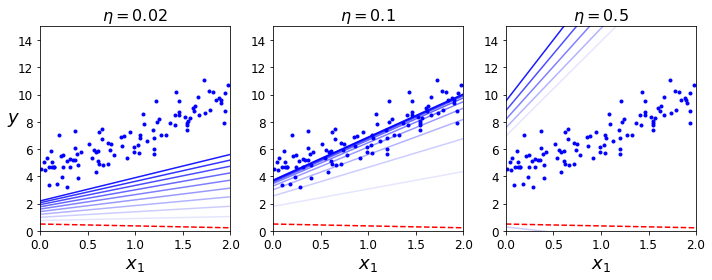

In [17]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

Links ist die Lernrate zu niedrig: Der Algorithmus wird die Lösung schließlich erreichen, aber es wird lange dauern. In der Mitte sieht die Lernrate ziemlich gut aus: In nur wenigen Iterationen ist er bereits zur Lösung konvergiert. Auf der rechten Seite ist die Lernrate zu hoch: Der Algorithmus weicht ab, springt überall herum und entfernt sich bei jedem Schritt immer weiter von der Lösung.

Um eine gute Lernrate zu finden, können Sie die Gittersuche verwenden (siehe Kapitel 2). Sie sollten jedoch die Anzahl der Iterationen begrenzen, damit die Gittersuche Modelle ausschließen kann, die zu lange brauchen, um zu konvergieren.

Sie fragen sich vielleicht, wie Sie die Anzahl der Iterationen festlegen sollen. Wenn sie zu niedrig ist, sind Sie noch weit von der optimalen Lösung entfernt, wenn der Algorithmus anhält; ist sie jedoch zu hoch, verschwenden Sie Zeit, während sich die Modellparameter nicht mehr ändern. Eine einfache Lösung besteht darin, eine sehr große Anzahl von Iterationen festzulegen, den Algorithmus aber zu unterbrechen, wenn der Gradientenvektor winzig wird, d. h. wenn seine Norm kleiner wird als eine winzige Zahl $\epsilon$ (die so genannte Toleranz), denn dies geschieht, wenn der Gradientenabstieg (fast) das Minimum erreicht hat.

## Stochastic Gradient Descent

Das Hauptproblem des Batch Gradientenabstiegs besteht darin, dass bei jedem Schritt die gesamte Trainingsmenge zur Berechnung der Gradienten herangezogen wird, was ihn bei einer großen Trainingsmenge sehr langsam macht. Im Gegensatz dazu wählt der stochastische Gradientenabstieg bei jedem Schritt eine zufällige Instanz aus der Trainingsmenge aus und berechnet die Gradienten nur auf der Grundlage dieser einen Instanz. Es liegt auf der Hand, dass der Algorithmus viel schneller ist, wenn er jeweils nur mit einer einzigen Instanz arbeitet, da er bei jeder Iteration nur sehr wenige Daten zu bearbeiten hat. Außerdem ist es so möglich, mit riesigen Trainingsmengen zu trainieren, da bei jeder Iteration nur eine Instanz im Speicher sein muss (Stochastic GD kann als Out-of-Core-Algorithmus implementiert werden; siehe Kapitel 1).

Andererseits ist dieser Algorithmus aufgrund seines stochastischen (d. h. zufälligen) Charakters weit weniger regelmäßig als der Batch Gradient Descent: Anstatt sanft zu sinken, bis sie das Minimum erreicht, springt die Kostenfunktion auf und ab und sinkt nur im Durchschnitt. Im Laufe der Zeit kommt sie dem Minimum sehr nahe, aber sobald sie es erreicht hat, springt sie weiter umher und kommt nie zur Ruhe (siehe Abbildung 4-9). Sobald der Algorithmus anhält, sind die endgültigen Parameterwerte zwar gut, aber nicht optimal.

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492032632/files/assets/mls2_0409.png)

Wenn die Kostenfunktion sehr unregelmäßig ist (wie in Abbildung 4-6), kann dies dem Algorithmus helfen, aus lokalen Minima herauszukommen, so dass der stochastische Gradientenabstieg eine bessere Chance hat, das globale Minimum zu finden als der Batch-Gradientenabstieg.

Zufälligkeit ist also gut, um aus lokalen Optima zu entkommen, aber schlecht, weil sie bedeutet, dass der Algorithmus sich nie am Minimum festsetzen kann. Eine Lösung für dieses Dilemma besteht darin, die Lernrate schrittweise zu verringern. Die Schritte beginnen mit großen Schritten (was zu schnellen Fortschritten und zur Vermeidung lokaler Minima beiträgt) und werden dann immer kleiner, so dass sich der Algorithmus auf dem globalen Minimum einpendeln kann. Dieser Prozess ähnelt dem simulierten Glühen, einem Algorithmus, der sich an den Prozess des Glühens in der Metallurgie anlehnt, bei dem geschmolzenes Metall langsam abgekühlt wird. Die Funktion, die die Lernrate bei jeder Iteration bestimmt, wird als Lernplan bezeichnet. Wenn die Lernrate zu schnell reduziert wird, kann es passieren, dass man in einem lokalen Minimum stecken bleibt oder sogar auf halbem Weg zum Minimum eingefroren wird. Wird die Lernrate zu langsam reduziert, kann es passieren, dass man lange Zeit um das Minimum herumspringt und am Ende eine suboptimale Lösung erhält, wenn man das Training zu früh beendet.

Dieser Code implementiert den stochastischen Gradientenabstieg unter Verwendung eines einfachen Lernplans:

In [18]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

Saving figure sgd_plot


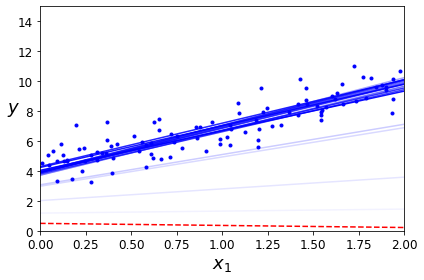

In [19]:
# SGD für 50 Epochen (Iterationen) mit einem Lernplan, um die Lernrate schrittweise zu verkleinern
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs): # Wie viele Durchläufe?
    for i in range(m): # Durch den ganzen Trainingssatz, aber einzelne Updates
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style, alpha=1 if i == 0 else (0 + i)/20)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
save_fig("sgd_plot")                                 # not shown
plt.show()                                           # not shown

Gemäß der Konvention iterieren wir in Runden von $m$ Iterationen; jede Runde wird als Epoche bezeichnet. Während der Batch Gradient Descent Code 1.000 Mal durch die gesamte Trainingsmenge iterierte, geht dieser Code nur 50 Mal durch die Trainingsmenge und erreicht eine ziemlich gute Lösung:

In [20]:
theta

array([[4.21076011],
       [2.74856079]])

Zur Durchführung einer linearen Regression unter Verwendung von Stochastic GD mit Scikit-Learn können Sie die Klasse `SGDRegressor` verwenden, die standardmäßig die quadratische Fehlerkostenfunktion optimiert. Der folgende Code läuft für maximal 1.000 Epochen oder bis der Verlust um weniger als 0,001 während einer Epoche fällt (`max_iter=1000`, `tol=1e-3`). Er beginnt mit einer Lernrate von 0,1 (`eta0=0,1`) und verwendet den Standard-Lernplan (der sich vom vorhergehenden unterscheidet). Und schließlich wird keine Regularisierung verwendet (`penalty=None`; mehr dazu in Kürze):

In [21]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.19984658]), array([2.73198364]))

## Mini-batch gradient descent

Der letzte Gradientenabstiegsalgorithmus, den wir uns ansehen werden, heißt Mini-Batch Gradientenabstieg. Er ist einfach zu verstehen, wenn Sie Batch und Stochastic Gradient Descent kennen: Bei jedem Schritt werden die Gradienten nicht auf der Grundlage des gesamten Trainingssatzes (wie bei Batch GD) oder auf der Grundlage einer einzigen Instanz (wie bei Stochastic GD) berechnet, sondern auf der Grundlage kleiner zufälliger Sätze von Instanzen, die Mini-Batches genannt werden. Der Hauptvorteil von Mini-batch GD gegenüber Stochastic GD besteht darin, dass Sie einen Leistungsschub durch die Hardware-Optimierung von Matrixoperationen erhalten können, insbesondere bei Verwendung von GPUs.

Der Fortschritt des Algorithmus im Parameterraum ist weniger sprunghaft als bei der stochastischen GD, insbesondere bei ziemlich großen Mini-Batches. Infolgedessen wird sich Mini-batch GD am Ende etwas näher am Minimum bewegen als Stochastic GD, aber es kann schwieriger sein, aus lokalen Minima zu entkommen (im Falle von Problemen, die unter lokalen Minima leiden, im Gegensatz zu Linear Regression). Abbildung 4-11 zeigt die Wege, die die drei Gradientenabstiegsalgorithmen während des Trainings im Parameterraum nehmen. Sie enden alle in der Nähe des Minimums, aber der Pfad von Batch GD hält tatsächlich am Minimum an, während sowohl Stochastic GD als auch Mini-batch GD weiter herumlaufen. Vergessen Sie jedoch nicht, dass Batch GD für jeden Schritt sehr viel Zeit benötigt, und Stochastic GD und Mini-batch GD würden das Minimum ebenfalls erreichen, wenn Sie einen guten Lernplan verwenden.

![](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492032632/files/assets/mls2_0411.png)

In [23]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [24]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [25]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


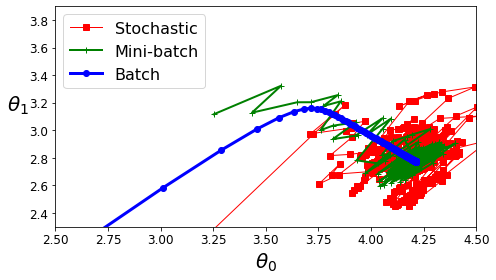

In [26]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

Vergleichen wir die bisher besprochenen Algorithmen für die lineare Regression ($m$ ist die Anzahl der Trainingsinstanzen und $n$ ist die Anzahl der Merkmale); siehe Tabelle 4-1.

Table 4-1. Comparison of algorithms for Linear Regression

| Algorithm | Large m | Out-of-core support | Large n | Hyperparams | Scaling required | Scikit-Learn | 
|---|---|---|---|---|---|---|
| Normal Equation | Fast| No | Slow | 0 | No |N/A|
| SVD | Fast | No | Slow| 0 | No | `LinearRegression` | 
| Batch GD | Slow |  No | Fast | 2 | Yes | `SGDRegressor` | 
| Stochastic GD | Fast | Yes |Fast | ≥2 | Yes | `SGDRegressor` |
| Mini-batch GD | Fast |Yes |  Fast | ≥2 | Yes | `SGDRegressor` | 

# Polynomial Regression

Was ist, wenn Ihre Daten komplexer sind als eine gerade Linie? Überraschenderweise können Sie ein lineares Modell verwenden, um nichtlineare Daten anzupassen. Eine einfache Möglichkeit besteht darin, Potenzen jedes Merkmals als neue Merkmale hinzuzufügen und dann ein lineares Modell auf diesen erweiterten Satz von Merkmalen zu trainieren. Diese Technik wird als Polynomielle Regression bezeichnet.

Schauen wir uns ein Beispiel an. Erzeugen wir zunächst einige nichtlineare Daten, die auf einer einfachen quadratischen Gleichung7 basieren (plus etwas Rauschen; siehe Abbildung 4-12):

In [27]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [28]:
# Erzeuge 100 Trainingsdaten auf Basis einer Parabel
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Saving figure quadratic_data_plot


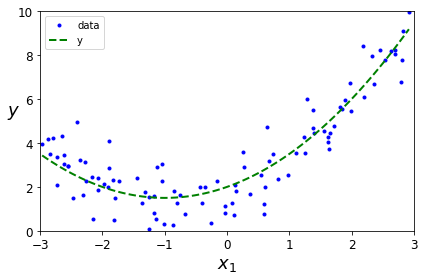

In [29]:
plt.plot(X, y, "b.", label="data")
xx = np.linspace(X.min(), X.max(), 100)
plt.plot(xx, 0.5 * xx**2 + xx + 2, "g--", lw=2, label="y")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.legend()

save_fig("quadratic_data_plot")

Es ist klar, dass eine gerade Linie niemals richtig zu diesen Daten passen wird. Verwenden wir also die Klasse `PolynomialFeatures` von Scikit-Learn, um unsere Trainingsdaten zu transformieren, indem wir das Quadrat (Polynom zweiten Grades) jedes Merkmals im Trainingssatz als neues Merkmal hinzufügen (in diesem Fall gibt es nur ein Merkmal):

In [30]:
# Nutze PolynomialFeatures von sklearn.preprocessing, um Potenzen zweiten Grades zu den Trainingsdaten hinzuzufügen
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [31]:
print("original:", X[0])
print("transformed:", X_poly[0])

original: [-0.75275929]
transformed: [-0.75275929  0.56664654]


`X_poly` enthält nun das ursprüngliche Merkmal von $X$ plus das Quadrat dieses Merkmals. Nun können Sie ein `LinearRegression`-Modell an diese erweiterten Trainingsdaten anpassen (Abbildung 4-13):

In [32]:
# Trainiere eine lin. Reg. auf den Trainingsdaten X_poly
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_ # Vergleiche mit wahren Werten!

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Saving figure quadratic_predictions_plot


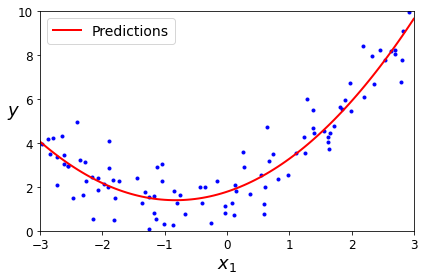

In [33]:
# Visualisiere das erlernte lineare Modell
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

Nicht schlecht: Das geschätzte Modell lautet $\hat{y} = 0.56x_1^2+0.93x_1 + 1.78$, wohingegen die ursprüngliche Funktion in Wirklichkeit $y = 0.5x_1^2 + 1.0x_1 + 2.0 + \text{Gaussian noise}$ ist.

Beachten Sie, dass die Polynomialregression bei mehreren Merkmalen in der Lage ist, Beziehungen zwischen den Merkmalen zu finden (was ein einfaches Modell der linearen Regression nicht kann). Dies wird durch die Tatsache ermöglicht, dass `PolynomialFeatures` auch alle Kombinationen von Merkmalen bis zum gegebenen Grad addiert. Wenn es zum Beispiel zwei Merkmale $a$ und $b$ gibt, würde `PolynomialFeatures` mit Grad=3 nicht nur die Merkmale $a^2$, $a^3$, $b^2$ und $b^3$ hinzufügen, sondern auch die Kombinationen $ab$, $a^2b$ und $ab^2$.

**Warnung**: `PolynomialFeatures(degree=d)` wandelt ein Array mit $n$ Merkmalen in ein Array mit $(n + d)! / d!n!$ Features um, wobei $n!$ die Fakultät von $n$ ist, was gleichbedeutend mit dem Produkt $1 × 2 × 3 × ⋯ × n$ ist. Vorsicht vor der kombinatorischen Explosion der Anzahl der Merkmale!

# Lernkurven

Wenn Sie eine polynomiale Regression hohen Grades durchführen, werden Sie die Trainingsdaten wahrscheinlich viel besser anpassen als mit einer einfachen linearen Regression. In Abbildung 4-14 wird beispielsweise ein 300-Grad-Polynom-Modell auf die vorangegangenen Trainingsdaten angewendet und das Ergebnis mit einem rein linearen Modell und einem quadratischen Modell (Polynom zweiten Grades) verglichen. Beachten Sie, wie sich das 300-Grad-Polynom-Modell bewegt, um den Trainingsinstanzen so nahe wie möglich zu kommen.

Saving figure high_degree_polynomials_plot


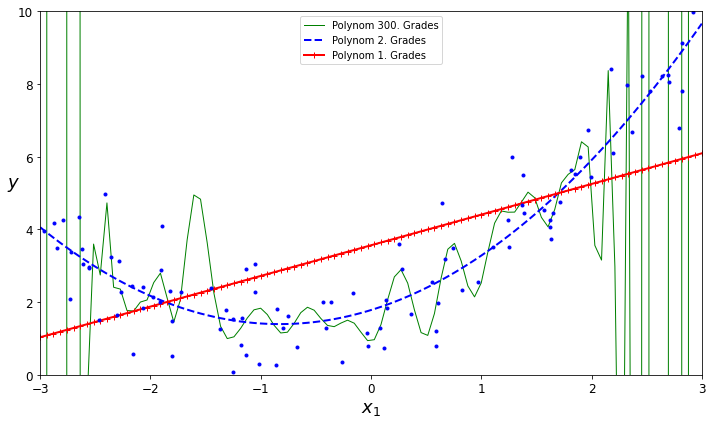

In [34]:
# Vergleiche ein lineares Modell mit einem Polynom 2. und 300. Grades
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

plt.figure(figsize=(10, 6))
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=f"Polynom {degree}. Grades", linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper center")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

Dieses polynomiale Regressionsmodell hohen Grades passt sich den Trainingsdaten zu stark an, während das lineare Modell sie zu wenig anpasst. Das Modell, das in diesem Fall am besten verallgemeinert, ist das quadratische Modell, was sinnvoll ist, da die Daten mit einem quadratischen Modell erzeugt wurden. Im Allgemeinen wissen Sie jedoch nicht, welche Funktion die Daten erzeugt hat. Wie können Sie also entscheiden, wie komplex Ihr Modell sein sollte? Wie können Sie feststellen, ob Ihr Modell die Daten zu gut oder zu schlecht abbildet?

In Kapitel 2 haben Sie die Kreuzvalidierung verwendet, um eine Schätzung der Generalisierungsleistung eines Modells zu erhalten. Wenn ein Modell bei den Trainingsdaten gut abschneidet, aber nach den Metriken der Kreuzvalidierung schlecht verallgemeinert, dann ist Ihr Modell überangepasst. Wenn es in beiden Fällen schlecht abschneidet, liegt eine Unteranpassung vor. Dies ist eine Möglichkeit, um festzustellen, ob ein Modell zu einfach oder zu komplex ist.

Eine andere Möglichkeit, dies festzustellen, ist ein Blick auf die Lernkurven: Dies sind Diagramme der Leistung des Modells auf der Trainingsmenge und der Validierungsmenge in Abhängigkeit von der Größe der Trainingsmenge (oder der Trainingsiteration). Um die Diagramme zu erstellen, trainieren Sie das Modell mehrmals auf unterschiedlich großen Teilmengen des Trainingssatzes. Der folgende Code definiert eine Funktion, die bei Vorliegen einiger Trainingsdaten die Lernkurven eines Modells aufzeichnet:

In [35]:
# Visualisiere die Lernkurve des Modells für iteratives Training (1 neues sample pro Iteration)
# Bestimme dazu die Performance auf dem Trainings- und einem Validierungsdatensatz
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

Saving figure underfitting_learning_curves_plot


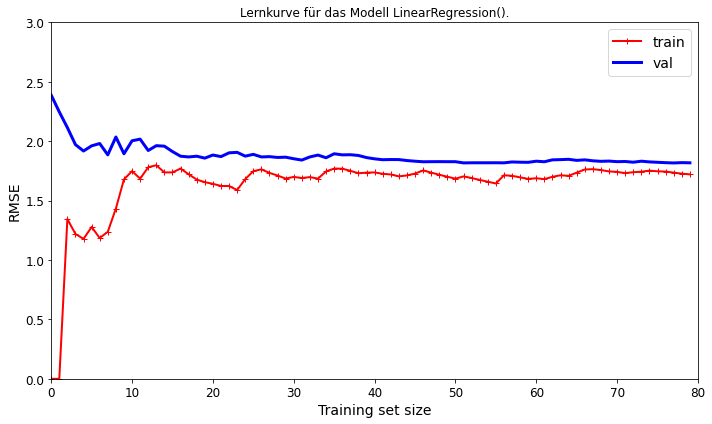

In [36]:
# Visualisiere die Lernkurve für die lin. Reg.
lin_reg = LinearRegression()
plt.figure(figsize=(10, 6))
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
plt.title(f"Lernkurve für das Modell {lin_reg}.")
save_fig("underfitting_learning_curves_plot")   # not shown

Diese Lernkurven sind typisch für ein Modell, das sich nicht gut anpasst. Beide Kurven haben ein Plateau erreicht; sie liegen nahe beieinander und sind ziemlich hoch.

**Tipp**: Wenn Ihr Modell den Trainingsdaten nicht gerecht wird, hilft es nicht, mehr Trainingsbeispiele hinzuzufügen. Sie müssen ein komplexeres Modell verwenden oder sich bessere Merkmale ausdenken.


Betrachten wir nun die Lernkurven eines Polynommodells 10. Grades für dieselben Daten (Abbildung 4-16):

Saving figure learning_curves_plot


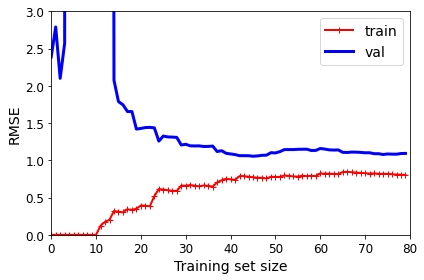

In [37]:
# Visualisiere die Lernkurve für die Polynomielle Regression 10. Grades
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
save_fig("learning_curves_plot")  # not shown
plt.show()                        # not shown

Diese Lernkurven sehen ein wenig aus wie die vorherigen, aber es gibt zwei sehr wichtige Unterschiede:

- Der Fehler bei den Trainingsdaten ist viel geringer als beim Modell der linearen Regression.
- Es gibt eine Lücke zwischen den Kurven. Das bedeutet, dass das Modell bei den Trainingsdaten deutlich besser abschneidet als bei den Validierungsdaten, was das Kennzeichen eines Overfitting-Modells ist. Wenn Sie jedoch einen viel größeren Trainingssatz verwenden würden, würden sich die beiden Kurven weiter annähern.

**Tipp**: Eine Möglichkeit, ein Overfitting-Modell zu verbessern, besteht darin, es mit mehr Trainingsdaten zu füttern, bis der Validierungsfehler den Trainingsfehler erreicht.


## Der Kompromiss zwischen Bias und Varianz

Ein wichtiges theoretisches Ergebnis der Statistik und des maschinellen Lernens ist die Tatsache, dass der Generalisierungsfehler eines Modells als Summe dreier sehr unterschiedlicher Fehler ausgedrückt werden kann:

**Bias**

Dieser Teil des Verallgemeinerungsfehlers ist auf falsche Annahmen zurückzuführen, z. B. auf die Annahme, dass die Daten linear sind, obwohl sie in Wirklichkeit quadratisch sind. Ein Modell mit hohem Bias passt sich höchstwahrscheinlich nicht an die Trainingsdaten an.

**Varianz**

Dieser Teil ist auf die übermäßige Empfindlichkeit des Modells gegenüber kleinen Variationen in den Trainingsdaten zurückzuführen. Ein Modell mit vielen Freiheitsgraden (z. B. ein Polynommodell mit hohem Grad) hat wahrscheinlich eine hohe Varianz und passt sich daher nicht an die Trainingsdaten an.

**Unreduzierbarer Fehler**

Dieser Teil ist auf das Rauschen der Daten selbst zurückzuführen. Die einzige Möglichkeit, diesen Teil des Fehlers zu reduzieren, besteht darin, die Daten zu bereinigen (z. B. die Datenquellen zu reparieren, wie defekte Sensoren, oder Ausreißer zu erkennen und zu entfernen).

Eine Erhöhung der Komplexität eines Modells erhöht in der Regel seine Varianz und verringert seine Verzerrung. Umgekehrt erhöht eine Verringerung der Komplexität eines Modells seine Verzerrung und verringert seine Varianz. Aus diesem Grund spricht man von einem Trade-off.

# Regularized Linear Models

Wie wir in den Kapiteln 1 und 2 gesehen haben, besteht eine gute Möglichkeit zur Verringerung der Überanpassung darin, das Modell zu **regularisieren** (d. h. es einzuschränken): Je weniger Freiheitsgrade es hat, desto schwieriger wird es, die Daten zu überanpassen. Eine einfache Möglichkeit zur Regularisierung eines Polynommodells besteht darin, die Anzahl der Polynomgrade zu verringern.

Bei einem linearen Modell wird die Regularisierung in der Regel durch Einschränkung der Gewichte des Modells erreicht. Wir werden uns nun die Ridge-Regression, die Lasso-Regression und das Elastic Net ansehen, die drei verschiedene Möglichkeiten zur Einschränkung der Gewichte bieten.

## Ridge Regression

Die Ridge-Regression (auch Tikhonov-Regularisierung genannt) ist eine regularisierte Version der linearen Regression: Der Kostenfunktion wird ein Regularisierungsterm in Höhe von $\alpha \sum_{i=1}^n \theta_i^2$ hinzugefügt. Dadurch wird der Lernalgorithmus gezwungen, sich nicht nur an die Daten anzupassen, sondern auch die Modellgewichte so klein wie möglich zu halten. Beachten Sie, dass der Regularisierungsterm nur während des Trainings zur Kostenfunktion hinzugefügt werden sollte. Sobald das Modell trainiert ist, möchten Sie das unregulierte Leistungsmaß verwenden, um die Leistung des Modells zu bewerten.

Der Hyperparameter $\alpha$ bestimmt, wie stark Sie das Modell regulieren wollen. Ist $\alpha = 0$, dann ist die Ridge-Regression einfach eine lineare Regression. Wenn $\alpha$ sehr groß ist, enden alle Gewichte sehr nahe bei Null und das Ergebnis ist eine flache Linie, die durch den Mittelwert der Daten verläuft. Gleichung 4-8 zeigt die Kostenfunktion der Ridge-Regression.

$$ J(\mathbf{\theta}) = MSE(\mathbf{\theta}) + \alpha \cfrac{1}{2} \sum_{i=1}^n \theta_i^2 $$

Man beachte, dass der Biasterm $\theta_0$ nicht regularisiert ist (die Summe beginnt bei $i = 1$, nicht bei $0$). Wenn wir $\mathbf{w}$ als den Vektor der Merkmalsgewichte ($\theta_1$ bis $\theta_n$) definieren, dann ist der Regularisierungsterm gleich $\frac{1}{2}(\parallel \mathbf{w} \parallel_2)^2$, wobei $\parallel \mathbf{w} \parallel^2$ die $l_2$-Norm des Gewichtsvektors darstellt. Für den Gradientenabstieg wird einfach $\alpha \mathbf{w}$ zum MSE-Gradientenvektor (Gleichung 4-6) hinzugefügt.

**Warnung**: Es ist wichtig, die Daten zu skalieren (z. B. mit einem `StandardScaler`), bevor die Ridge-Regression durchgeführt wird, da sie empfindlich auf die Skalierung der Eingangsmerkmale reagiert. Dies gilt für die meisten regularisierten Modelle.


In [38]:
# Wir erzeugen uns zunächst wieder Trainingsdaten
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

Abbildung 4-17 zeigt verschiedene Ridge-Modelle, die auf einigen linearen Daten mit unterschiedlichen $\alpha$-Werten trainiert wurden. Auf der linken Seite werden einfache Ridge-Modelle verwendet, die zu linearen Vorhersagen führen. Rechts werden die Daten zunächst mit `PolynomialFeatures(degree=10)` erweitert, dann mit einem `StandardScaler` skaliert und schließlich die Ridge-Modelle auf die resultierenden Features angewendet: Dies ist Polynomial Regression mit Ridge-Regularisierung. Beachten Sie, dass eine Erhöhung von $\alpha$ zu flacheren (d. h. weniger extremen, vernünftigeren) Vorhersagen führt, wodurch die Varianz des Modells verringert, aber seine Verzerrung erhöht wird.


Saving figure ridge_regression_plot


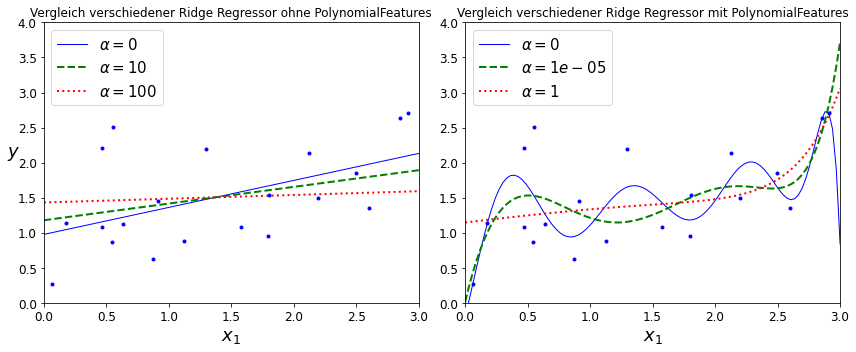

In [39]:
# Jetzt vergleichen wir verschiedene Modelle mit verschieden starker Regularisierung (alpha-Wert)
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(12,5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.title("Vergleich verschiedener Ridge Regressor ohne PolynomialFeatures")
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.title("Vergleich verschiedener Ridge Regressor mit PolynomialFeatures")

plt.tight_layout()
save_fig("ridge_regression_plot")

**Hinweis**: Um zukunftssicher zu sein, setzen wir `max_iter=1000` und `tol=1e-3`, da dies die Standardwerte in Scikit-Learn 0.21 sein werden.

Wie bei der linearen Regression können wir die Ridge-Regression entweder durch Berechnung einer Gleichung in geschlossener Form oder durch Gradientenabstieg durchführen. Die Vor- und Nachteile sind die gleichen. Gleichung 4-9 zeigt die Lösung in geschlossener Form, wobei A die $(n + 1) × (n + 1)$ Identitätsmatrix ist, mit Ausnahme einer 0 in der linken oberen Zelle, die dem Bias-Term entspricht.

$$ \hat{\mathbf{\theta}} = \left(X^T X + \alpha A \right)^{-1}X^T \mathbf{y}$$

Im Folgenden wird beschrieben, wie die Ridge-Regression mit Scikit-Learn unter Verwendung einer geschlossenen Lösung durchgeführt wird (eine Variante von Gleichung 4-9, die eine Matrixfaktorisierungstechnik von André-Louis Cholesky verwendet):

In [40]:
# geschlossene Lösung
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [41]:
# SGD Lösung
# ‘sag’ uses a Stochastic Average Gradient descent, and ‘saga’ uses its improved, unbiased version named SAGA. 
# Both methods also use an iterative procedure
# and are often faster than other solvers when both n_samples and n_features are large. 
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

In [42]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42) # Versuche, tol zu ändern
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

Der Penalty-Hyperparameter legt den Typ des zu verwendenden Regularisierungsterms fest. Die Angabe von "l2" bedeutet, dass SGD einen Regularisierungsterm zur Kostenfunktion hinzufügen soll, der dem halben Quadrat der $l_2$-Norm des Gewichtsvektors entspricht: dies ist einfach Ridge Regression.

## Lasso Regression

/Users/miay/miniconda3/envs/ml-mit-python/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  model = cd_fast.enet_coordinate_descent(


Saving figure lasso_regression_plot


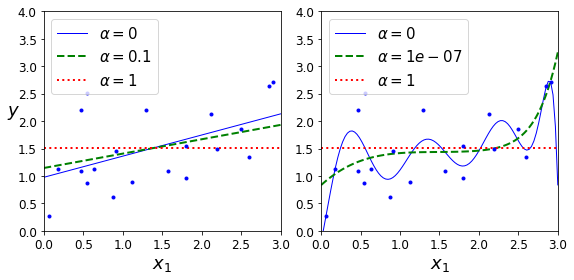

In [43]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

In [44]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

## Elastic Net

In [45]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## Early Stopping

In [46]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [47]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

Create the graph:

Saving figure early_stopping_plot


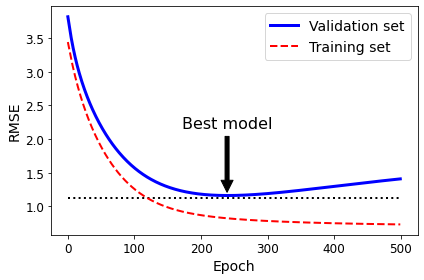

In [48]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [49]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [51]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

Saving figure lasso_vs_ridge_plot


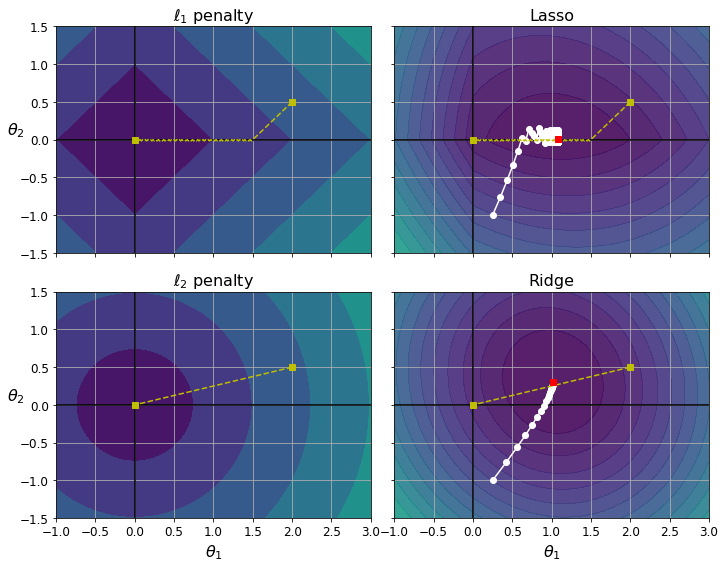

In [52]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

save_fig("lasso_vs_ridge_plot")
plt.show()

# Logistic Regression

## Decision Boundaries

Saving figure logistic_function_plot


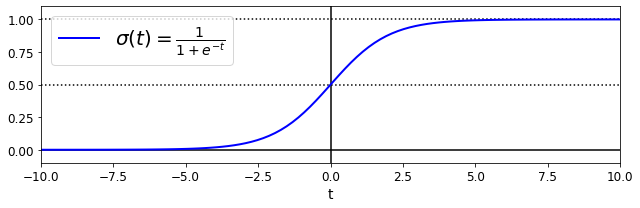

In [53]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

In [54]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [55]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [56]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

/var/folders/27/_w012g5n1c55m7kh9r8jyn488xbh04/T/ipykernel_45298/2130579894.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0


**Note**: To be future-proof we set `solver="lbfgs"` since this will be the default value in Scikit-Learn 0.22.

In [57]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

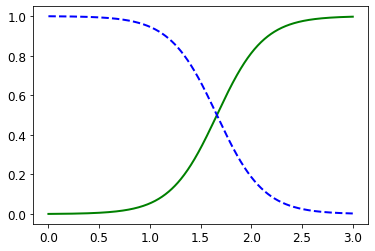

In [58]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

The figure in the book actually is actually a bit fancier:

/Users/miay/miniconda3/envs/ml-mit-python/lib/python3.10/site-packages/matplotlib/patches.py:1444: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.verts = np.dot(coords, M) + [


Saving figure logistic_regression_plot


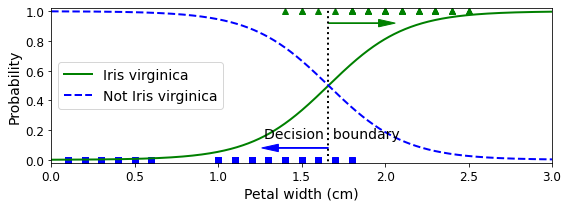

In [59]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

In [60]:
decision_boundary

array([1.66066066])

In [61]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

## Softmax Regression

/var/folders/27/_w012g5n1c55m7kh9r8jyn488xbh04/T/ipykernel_45298/3823961991.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int)


Saving figure logistic_regression_contour_plot


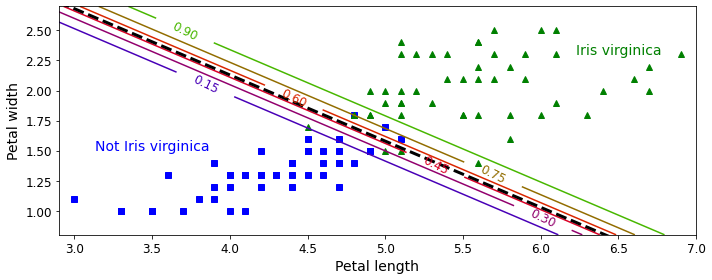

In [62]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

In [63]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

Saving figure softmax_regression_contour_plot


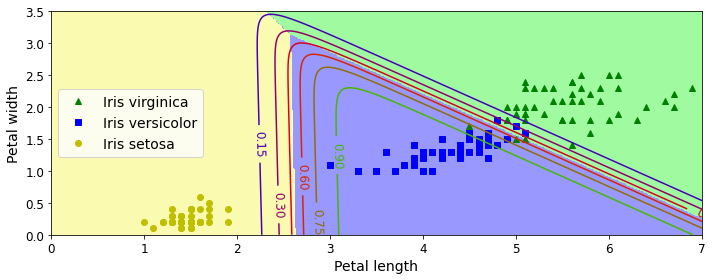

In [64]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

In [65]:
softmax_reg.predict([[5, 2]])

array([2])

In [66]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

# Exercise solutions

## 1. to 11.

See appendix A.

## 12. Batch Gradient Descent with early stopping for Softmax Regression
(without using Scikit-Learn)

Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.

In [67]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

We need to add the bias term for every instance ($x_0 = 1$):

In [68]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

And let's set the random seed so the output of this exercise solution is reproducible:

In [69]:
np.random.seed(2042)

The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but the point of this exercise is to try understand the algorithms by implementing them manually. So here is one possible implementation:

In [70]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for ay given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance:

In [71]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

Let's test this function on the first 10 instances:

In [72]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [73]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [74]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [75]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

We are almost ready to start training. Let's define the number of inputs and outputs:

In [76]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [77]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693314
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.47292289721922487
3500 0.44824244188957774
4000 0.4278651093928793
4500 0.41060071429187134
5000 0.3956780375390374


And that's it! The Softmax model is trained. Let's look at the model parameters:

In [78]:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

Let's make predictions for the validation set and check the accuracy score:

In [79]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

Well, this model looks pretty good. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [80]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 6.629842469083912
500 0.5339667976629505
1000 0.5036400750148942
1500 0.49468910594603216
2000 0.4912968418075476
2500 0.48989924700933296
3000 0.4892990598451198
3500 0.4890351244397859
4000 0.4889173621830818
4500 0.4888643337449303
5000 0.4888403120738818


Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:

In [81]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Cool, perfect accuracy! We probably just got lucky with this validation set, but still, it's pleasant.

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [82]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109128
1500 0.5355752782580262
2000 0.5331959249285545
2500 0.5325946767399382
2765 0.5325460966791898
2766 0.5325460971327978 early stopping!


In [83]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

Still perfect, but faster.

Now let's plot the model's predictions on the whole dataset:

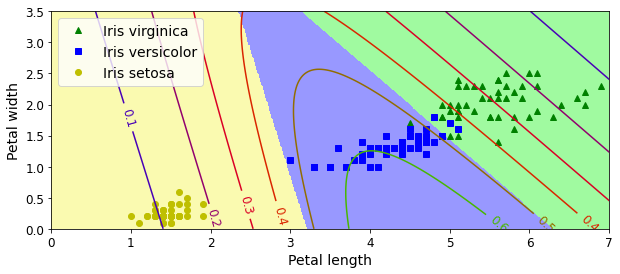

In [84]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

And now let's measure the final model's accuracy on the test set:

In [85]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

Our perfect model turns out to have slight imperfections. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.